
# Overfitting, the Bias-Variance tradeoff, Regularization, and Double Descent

These notes are modified and extended from [notes](https://github.com/kuleshov/cornell-cs5785-2022-applied-ml/blob/main/slides/lecture5-regularization.ipynb) by __Volodymyr Kuleshov__ at Cornell Tech.

In [1]:
## Preamble / required packages
import numpy as np
np.random.seed(0)

## Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

import warnings
## Comment this out to activate warnings
warnings.filterwarnings('ignore')


# Overfitting and Underfitting

We have seen a number of supervised learning algorithms. 

Next, let's look at why they work (and why sometimes they don't).

# Polynomial Regression

In 1D polynomial regression, we want to fit a model
$$ f_\theta(x) := \theta^\top \phi(x) = \sum_{j=0}^p \theta_j x^j $$
that is linear in $\theta$ but non-linear in $x$ because the features 
$$\phi(x) = [1\; x\; \ldots\; x^p]$$ 
are non-linear. Using these features, we can fit any polynomial of degree $p$ by first transforming the features and then fitting a linear model.

Text(0, 0.5, 'y')

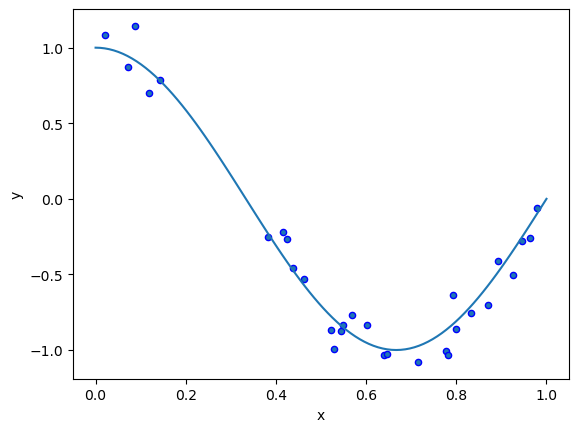

In [13]:
true_fn = lambda X: np.cos(1.5 * np.pi * X) # what do we think will be a good model?

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = true_fn(X) + np.random.randn(n_samples) * 0.1

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

plt.xlabel("x")
plt.ylabel("y")


## The Vandermonde matrix

The Vandermonde matrix $\Phi$ is a matrix whose rows are the features $\phi(x)$ for a set of points $x_1,\ldots,x_n$. For example, if we have $n=3$ points $x_1=1$, $x_2=2$, $x_3=3$, and $p=2$, then the Vandermonde matrix is
$$
\begin{bmatrix}
1 & 1 & 1 \\
1 & 2 & 4 \\
1 & 3 & 9
\end{bmatrix}
$$

In [3]:
xx = np.array([1, 2, 3])

print(np.vander(xx, 2, increasing=True), end='\n\n')

print(np.vander(xx, 3, increasing=True), end='\n\n')

print(np.vander(xx, 5, increasing=True), end='\n\n')

print(np.vander(xx, 10, increasing=True), end='\n\n')

[[1 1]
 [1 2]
 [1 3]]

[[1 1 1]
 [1 2 4]
 [1 3 9]]

[[ 1  1  1  1  1]
 [ 1  2  4  8 16]
 [ 1  3  9 27 81]]

[[    1     1     1     1     1     1     1     1     1     1]
 [    1     2     4     8    16    32    64   128   256   512]
 [    1     3     9    27    81   243   729  2187  6561 19683]]





### Solving yet another least-squares problem

In principle, we can simply fit a polynomial of degree $p$ to a set of points $(x_1,y_1),\ldots,(x_n,y_n)$ by solving the linear system $\Phi\theta = y$.
$$
\begin{bmatrix}
1 & x_1 & x_1^2 & \ldots & x_1^p \\
1 & x_2 & x_2^2 & \ldots & x_2^p \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_n & x_n^2 & \ldots & x_n^p
\end{bmatrix}

\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_p
\end{bmatrix}

=

\begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}
$$

### Properties of the Vandermonde matrix

+ The Vandermonde matrix $\Phi$ is a square matrix of size $n\times p$, where $n$ is the number of datapoints and $p$ is one plus the degree of the polynomial that we want to fit. In this sense, the "features" of the model are just higher powers of existing features, making the features redundant.
+ When $n = p$ and $\Phi$ is nonsingular if and only if the points $x_1,\ldots,x_n$ are all distinct. If the points are distinct, then the Vandermonde matrix is invertible and the linear system is guaranteed to have a unique solution. 
+ However, if $p > n$, then the Vandermonde matrix is rectangular and the linear system is not guaranteed to have a unique solution. Conversely, if $p < n$, then the Vandermonde matrix is rank-deficient and the linear system is not guaranteed to have a solution.

**However**, as the number of points increases, the Vandermonde matrix becomes ill-conditioned, which degrades the accuracy of the solution.


Text(0, 0.5, 'Condition number')

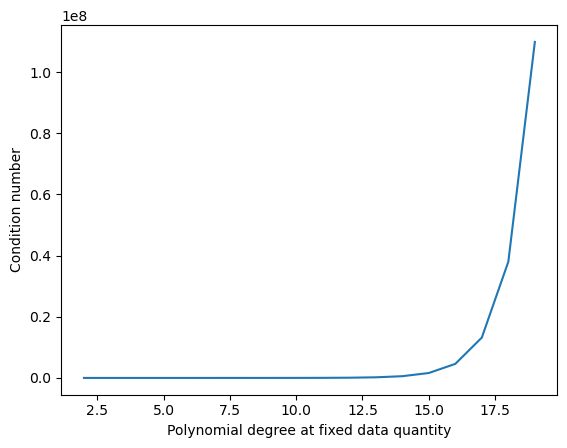

In [4]:
xx = np.array([1, 2, 3])

pvals = range(2, 20)
all_condition_numbers = []
for i in pvals:
    all_condition_numbers.append(np.linalg.cond(np.vander(xx, i, increasing=True)))

plt.plot(pvals, all_condition_numbers)
plt.xlabel('Polynomial degree at fixed data quantity')
plt.ylabel('Condition number')

## How can we interpret this effect?

Let's try making unit vectors out of the powers of our data vector

In [5]:
xx = np.array([1.0, 2.0])

phi = np.vander(xx, 10, increasing=True)

phi /= np.linalg.norm(phi, axis=0, keepdims=True)


Text(0.5, 1.0, 'All columns')

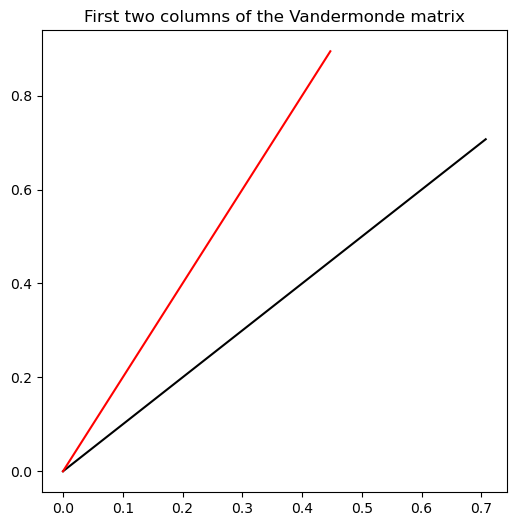

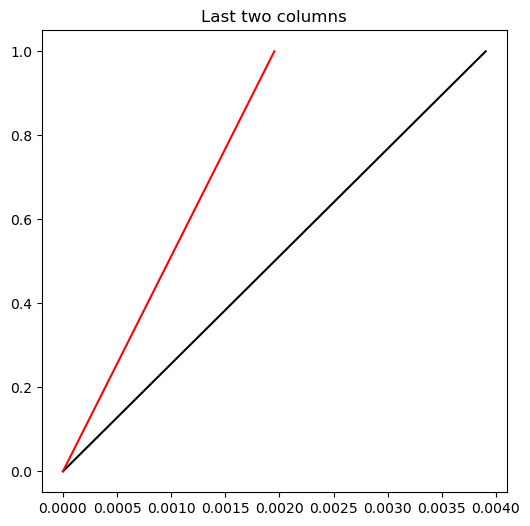

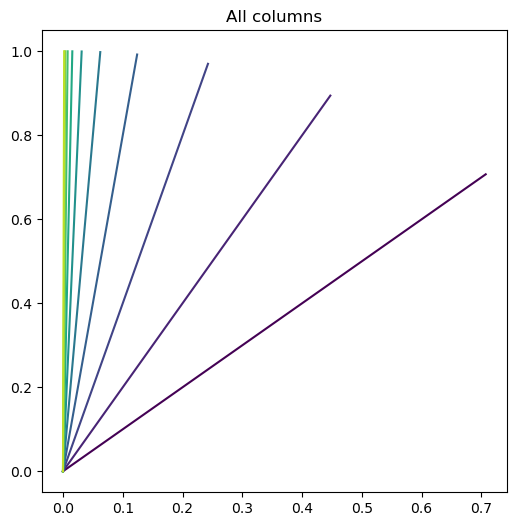

In [6]:
def plot_vector(vec, **kwargs):
    plt.plot([0, vec[0]], [0, vec[1]], **kwargs)

plt.figure(figsize=(6, 6))
plot_vector(phi[:, 0], color='k', label='First column')
plot_vector(phi[:, 1], color='r', label='Second column')
plt.title("First two columns of the Vandermonde matrix")


plt.figure(figsize=(6, 6))
plot_vector(phi[:, -2], color='k', label='First column')
plot_vector(phi[:, -1], color='r', label='Second column')
plt.title('Last two columns')

# plot with color gradient
plt.figure(figsize=(6, 6))
for i in range(10):
    plot_vector(phi[:, i], color=plt.cm.viridis(i / 10))
plt.title('All columns')


The largest element of our data vector $x$ begins to dominate at higher powers of $x$, causing the column vectors to become more and more similar to each other, and resulting in the least-squares problem becoming ill-conditioned.

**Nothing comes for free!** If we don't have sufficient features or measurement channels, we can't always just make up new ones as functions of our existing features. Eventually, redundancy catches up with us.


# Polynomials Fit the Data Well

+ When we switch from linear models to polynomials, we can better fit the data and increase the accuracy of our models.
+ Instead of directly computing the Vandermonde matrix, we can use the `PolynomialFeatures` class from `sklearn.preprocessing` to compute the Vandermonde matrix for us. Because it's built into scikit-learn, it's optimized for speed and memory usage, and it can easily be composed with other sklearn steps via the `Pipeline` class.

Although fitting a linear model does not work well, quadratic or cubic polynomials improve the fit.

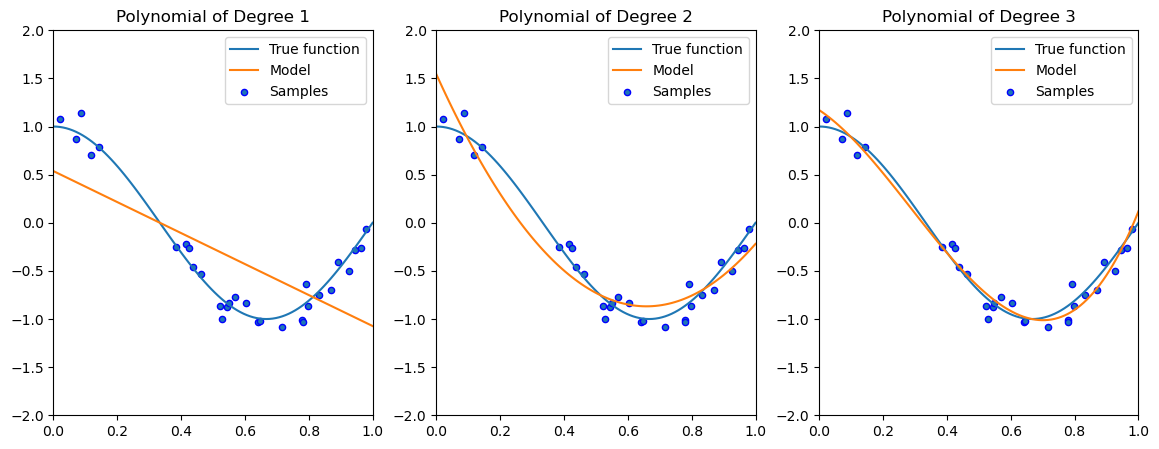

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

degrees = [1, 2, 3]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

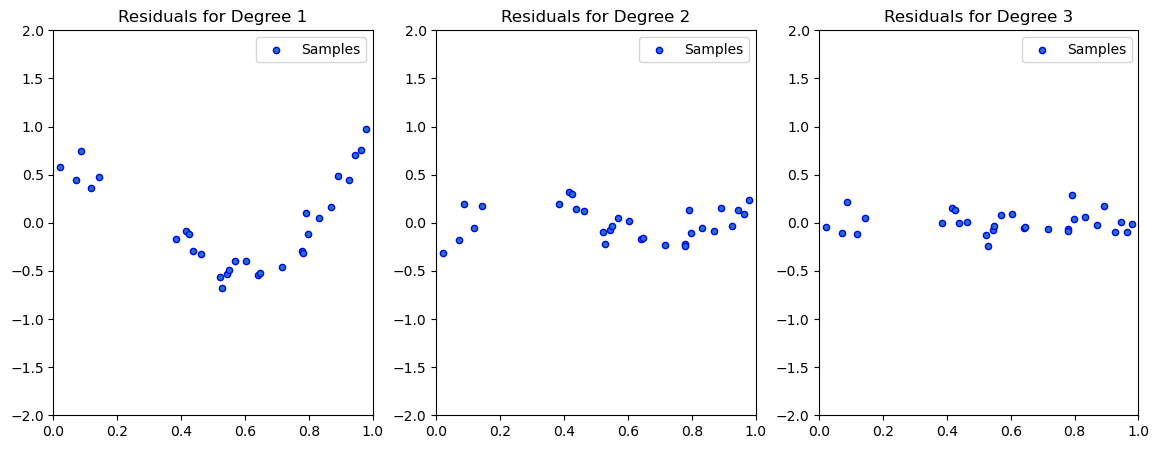

In [8]:
## Plot residuals for each model
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.scatter(X, y - pipeline.predict(X[:, np.newaxis]), edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Residuals for Degree {}".format(degrees[i]))

We can see one heuristic for determining whether we have chosen a sufficiently-expressive model: **Uniform scatter in the residuals**

Hypothetically, we want to view our data generating process as comprising a deterministic function $f$ and a random noise term $\epsilon$. We want to fit a model that is close to $f$ and that is able to capture everything except the variability in $\epsilon$.

$$
y_i = f(x_i) + \epsilon_i
$$

where $f(x_i) = \theta_0 + \theta_1 x_i + ...$ and $\epsilon_i$ is a random variable with mean 0 and variance $\sigma^2$. When we compute our residuals, we are computing the difference between the true values $y_i$ and our model's predictions $\hat{y}_i = f(x_i)$.
$$
r_i = y_i - f(x_i)
$$

Thus we want to $r_i$ to look like a zero-centered random distribution

# Why not go even higher?

+ Increase the degree of our polynomial improved our fit accuracy by producing a model that explained more of the variance in the data.
+ Our residuals appeared more uniform as well, suggesting that our model stopped underfitting


What happens if we further increase the degree of the polynomial?

Runge's phenomenon: can fit an $N$-point dataset perfectly with a polynomial of degree $N$.

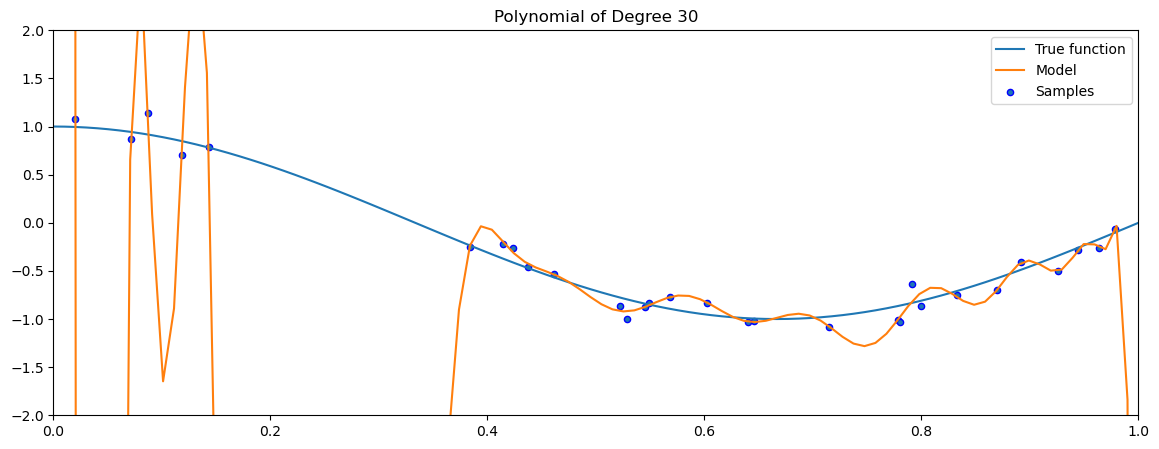

In [16]:
degrees = [30]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 1, 100)
    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

#### Let's plot the error on the training points

+ Nice.

In [17]:
## Compute train MSE
polynomial_features = PolynomialFeatures(degree=30)
linear_regression = LinearRegression()
pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
pipeline.fit(X[:, np.newaxis], y)
print("Train MSE: {}".format(np.mean((pipeline.predict(X[:, np.newaxis]) - y)**2)))


Train MSE: 0.0021424459297473427


### Let's plot the error on a test set

+ Uh-oh

In [18]:

## Compute test MSE
X_test = np.linspace(0, 1, 100)
print("Test MSE: {}".format(np.mean((pipeline.predict(X_test[:, np.newaxis]) - true_fn(X_test))**2)))

Test MSE: 39611.22849900287


As the degree of the polynomial increases to the size of the dataset, we are increasingly able to fit every point in the dataset.

However, this results in a highly irregular curve: its behavior outside the training set is wildly inaccurate.

Text(0, 0.5, 'Mean Squared Error')

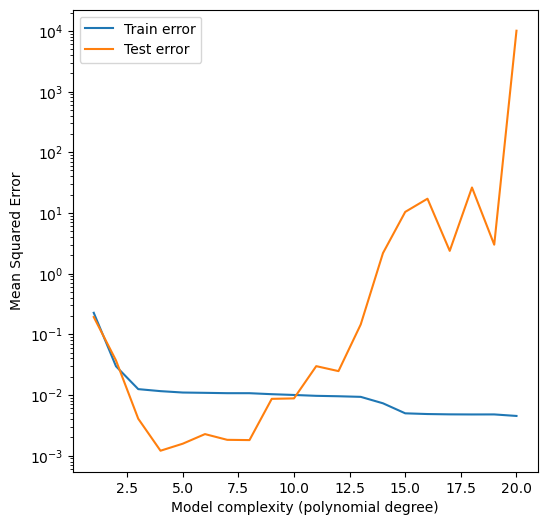

In [26]:
## Plot train and test error versus model size

degrees = range(1, 21)
train_errors = []
test_errors = []
for degree in degrees:
    polynomial_features = PolynomialFeatures(degree=degree,)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ## Compute errors on training and testing data
    train_errors.append(np.mean((pipeline.predict(X[:, np.newaxis]) - y)**2))
    test_errors.append(np.mean((pipeline.predict(X_test[:, np.newaxis]) - true_fn(X_test))**2))

plt.figure(figsize=(6, 6))
plt.semilogy(degrees, train_errors, label='Train error')
plt.semilogy(degrees, test_errors, label='Test error')
plt.legend(loc='best')
plt.xlabel('Model complexity (polynomial degree)')
plt.ylabel('Mean Squared Error')

# Overfitting

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (e.g., a high degree polynomial) fits the training dataset perfectly.
* But the model makes highly incorrect predictions outside this dataset, and doesn't generalize.

# Underfitting

A related failure mode is underfitting.

* A small model (e.g. a straight line), will not fit the training data well.
* Therefore, it will also not be accurate on new data.

<!-- __Underfitting__: On one hand, if the model is too small (like the linear model in the above example), it will not generalize well to unseen data because it is not sufficiently complex to fit the true structure of the dataset.

__Overfitting__: On the other hand, if the model is too expressive (like a high degree polynomial), we are going to fit the training dataset perfectly; however, the model will make wildly incorrect prediction at points right outside this dataset, and will also not generalize well to unseen data. -->

Finding the tradeoff between overfitting and underfitting is one of the main challenges in applying machine learning.

# Overfitting vs. Underfitting: Evaluation

We can diagnose overfitting and underfitting by measuring performance on a the held out testing dataset (not used for training).
* If training perforance is high but holdout performance is low, we are overfitting.
* If training perforance is low but holdout performance is low, we are underfitting.

The gap between train and test scores is one measure of overfitting. The larger the gap, the more overfitting.

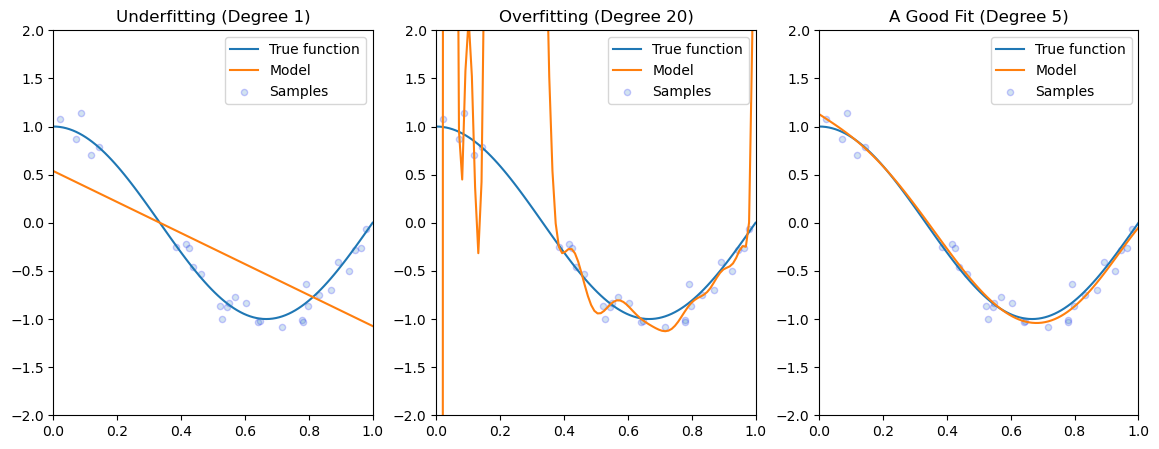

In [28]:
degrees = [1, 20, 5]
titles = ['Underfitting', 'Overfitting', 'A Good Fit']
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples", alpha=0.2)
    #ax.scatter(X_holdout[::3], y_holdout[::3], edgecolor='r', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("{} (Degree {})".format(titles[i], degrees[i]))
    #ax.text(0.05,-1.7, 'Holdout MSE: %.4f' % ((y_holdout-pipeline.predict(X_holdout[:, np.newaxis]))**2).mean())

# How to Fix Underfitting

What if our model doesn't fit the training set well? Try the following:
* Create richer features that will make the dataset easier to fit.
* Use a more expressive model family (neural nets vs. linear models)
* Try a better optimization procedure

# How to Fix Overfitting

We will see many ways of dealing with overftting, but here are some ideas:
* Use a simpler model family (linear models vs. neural nets)
* Keep the same model, but collect more training data
* (Today) Modify the training process to penalize overly complex models.

# Recall: Supervised Learning

Recall our intuitive definition of supervised learning.

1. First, we collect a dataset of labeled training examples.
2. We train a model to output accurate predictions on this dataset.
3. Abstractly, we see the model as attempting to learn about the generating process that produces new datapoints belonging to a single class

# What Is A Good Supervised Learning Model?

A good predictive model is one that makes __accurate predictions__ on __new data__ that it has not seen at training time.

* Accurate object detection in new scenes
* Correct translation of new sentences

Note that other definitions exist, e.g., does the model discover useful structure in the data?

# When Do We Get Good Performance on Held Out Data?

Suppose you have a classification model trained on images of cats and dogs. On which dataset will it perform better?

* A dataset of German shepherds and siamese cats?
* A dataset of birds and reptiles?

Clearly the former. Intuitively, ML models are accurate on new data if it is similar to the training data.

# Data Distribution

It is standard to assume that data is sampled from a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We  denote this as

$$x, y \sim \mathbb{P} \;\;\;\text{ or }\;\;\; \mathcal{D} \sim \mathbb{P}.$$

The training set $\mathcal{D} = \{(x^{(i)}, y^{(i)}) \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $\mathbb{P}$.

# Data Distribution: IID Sampling

The key assumption is that the training examples are *independent and identicaly distributed* (IID). 
* Each training example is from the same distribution.
* This distribution doesn't depend on previous training examples.

__Example__: Flipping a coin. Each flip has same probability of heads & tails and doesn't depend on previous flips.

__Counter-Example__: Yearly census data. The population in each year will be close to that of the previous year.

# Data Distribution: Motivation

Why assume that the dataset is sampled from a distribution?

* The process we model may be effectively random. If $y$ is a stock price, there is randomness in the market that cannot be captured by a deterministic model.

* There may be noise and randomness in the data collection process itself (e.g., collecting readings from an imperfect thermometer).

* We can use probability and statistics to analyze supervised learning algorithms and prove that they work.

# Holdout Dataset

A holdout dataset 

$$\tilde{\mathcal{D}} = \{(\dot{x}^{(i)}, \dot{y}^{(i)}) \mid i = 1,2,...,m\}$$

is sampled IID from the same distribution $\mathbb{P}$, and is distinct from the training dataset $\mathcal{D}$.

# Performance on a Holdout Set

Intuitively, a supervised model $f_\theta$ is "good" if it performs well on a holdout set $\tilde{\mathcal{D}}$ according to some measure

$$
\frac{1}{m} \sum_{i=1}^m L\left(\dot y^{(i)}, f_\theta(\dot x^{(i)}) \right).
$$

Here, $L : \mathcal{X}\times\mathcal{Y} \to \mathbb{R}$ is a performance metric or a loss function that we get to choose.

The choice of the performance metric $L$ depends on the specific problem and our goals:

* In classification, $L$ is often just accuracy: is $\dot y^{(i)} = f_\theta(\dot x^{(i)})$?
* $L$ can also implement other metrics: $R^2$ metric (see Homework 1) for regression, F1 score for document retrieval, etc.

For example, in a classification setting, we may be interested in the accuracy of the model. Thus, we want the % of misclassified inputs
$$
\frac{1}{m} \sum_{i=1}^m \mathbb{I}\left(\dot y^{(i)} \neq f_\theta(\dot x^{(i)}) \right)
$$
to be small. 

Here $\mathbb{I}\left( A \right)$ is an *indicator* function that equals one if $A$ is true and zero otherwise.

For large enough holdout sets $\dot{\mathcal{D}}$, we will be estimating performance on new data from $\mathbb{P}$.

# When Does Supervised Learning Work?

Let's now use these tools to say something about the performance of supervised learning algorithms.

* For large enough training sets $\mathcal{D} \sim \mathbb{P}$, most models will *generalize* to new data from $\mathbb{P}$. We should see the same performance on $\mathcal{D}$ and $\dot{\mathcal{D}} \sim \mathbb{P}$.

* When $\mathcal{D}$ is small, models may overfit $\mathcal{D}$ and perform poorly on new data from $\mathbb{P}$. We can detect this by evaluating them on $\dot{\mathcal{D}}$.


# Part 4: Regularization

We will now see a very important way to reduce overfitting: regularization.

# Review: Overfitting

Overfitting is one of the most common failure modes of machine learning.
* A very expressive model (a high degree polynomial) fits the training dataset perfectly.
* The model also makes wildly incorrect prediction outside this dataset, and doesn't generalize.

We can visualize overfitting by trying to fit a small dataset with a high degree polynomial.

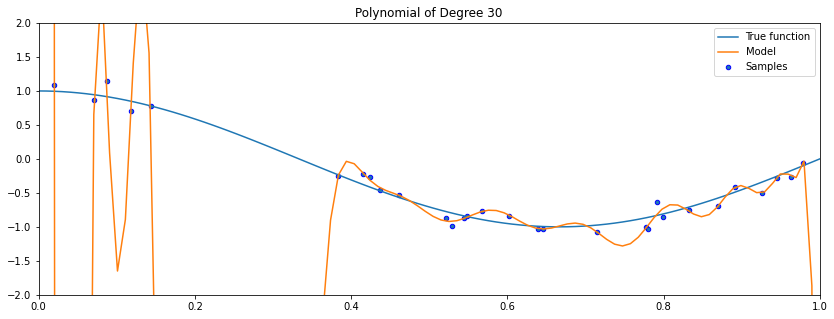

In [12]:
degrees = [30]
plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    X_test = np.linspace(0, 1, 100)
    ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Polynomial of Degree {}".format(degrees[i]))

# Regularization: Intuition

The idea of regularization is to penalize complex models that may overfit the data.

In the previous example, a less complex would rely less on polynomial terms of high degree.

# Regularization: Definition

The idea of regularization is to train models with an augmented objective $J : \mathcal{M} \to \mathbb{R}$ defined over a training dataset $\mathcal{D}$ of size $n$ as

$$J(f) = \underbrace{\frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f(x^{(i)}))}_\text{Learning Objective} + \underbrace{\lambda \cdot R(f)}_\text{New Regularization Term}$$

Let's dissect the components of this objective:

$$J(f) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f(x^{(i)})) + \lambda \cdot R(f).$$

* A loss function $L(y, f(x))$ such as the mean squared error.

* A regularizer $R : \mathcal{M} \to \mathbb{R}$ that penalizes models that are overly complex.

* A regularization parameter $\lambda > 0$, which controls the strength of the regularizer.

When the model $f_\theta$ is parametrized by parameters $\theta$, we also use the following notation:

$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f_\theta(x^{(i)})) + \lambda \cdot R(\theta).$$

# L2 Regularization: Definition

How can we define a regularizer $R: \mathcal{M} \to \mathbb{R}$ to control the complexity of a model $f \in \mathcal{M}$?

In the context of linear models $f_\theta(x) = \theta^\top x$, a widely used approach is L2 regularization, which defines the following objective:
$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \frac{\lambda}{2} \cdot ||\theta||_2^2.$$

Let's dissect the components of this objective.
$$J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \frac{\lambda}{2} \cdot ||\theta||_2^2.$$

* The regularizer $R : \Theta \to \mathbb{R}$ is the function 
$R(\theta) = ||\theta||_2^2 = \sum_{j=1}^d \theta_j^2.$ 
This is also known as the L2 norm of $\theta$.

* The regularizer penalizes large parameters. This prevents us from relying on any single feature and penalizes very irregular solutions.

* L2 regularization can be used with most models (linear, neural, etc.)

# L2 Regularization for Polynomial Regression

Let's consider an application to the polynomial model we have seen so far. Given polynomial features $\phi(x)$, we optimize the following objective:

$$ J(\theta) = \frac{1}{2n} \sum_{i=1}^n \left( y^{(i)} - \theta^\top \phi(x^{(i)}) \right)^2 + \frac{\lambda}{2} \cdot ||\theta||_2^2. $$


We implement regularized and polynomial regression of degree 15 on three random training sets sampled from the same distribution.

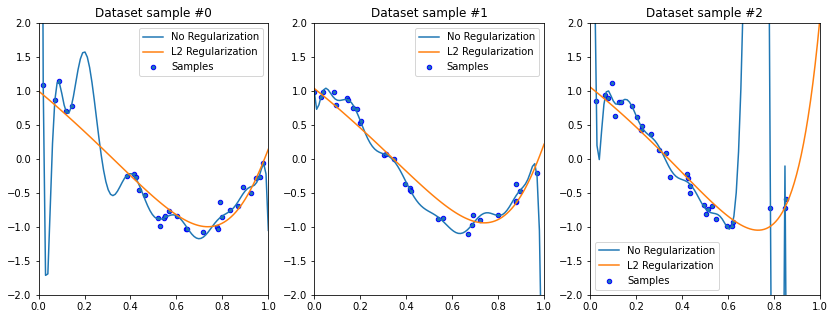

In [13]:
from sklearn.linear_model import Ridge

degrees = [15, 15, 15]
plt.figure(figsize=(14, 5))
for idx, i in enumerate(range(len(degrees))):
    # sample a dataset
    np.random.seed(idx)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = true_fn(X) + np.random.randn(n_samples) * 0.1

    # fit a least squares model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    
    # fit a Ridge model
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = Ridge(alpha=0.1) # sklearn uses alpha instead of lambda
    pipeline2 = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline2.fit(X[:, np.newaxis], y)    

    # visualize results
    ax = plt.subplot(1, len(degrees), i + 1)
    # ax.plot(X_test, true_fn(X_test), label="True function")    
    ax.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="No Regularization")
    ax.plot(X_test, pipeline2.predict(X_test[:, np.newaxis]), label="L2 Regularization")    
    ax.scatter(X, y, edgecolor='b', s=20, label="Samples")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 2))
    ax.legend(loc="best")
    ax.set_title("Dataset sample #{}".format(idx))

In order to define a very irregular function, we need very large polynomial weights.

Forcing the model to use small weights prevents it from learning irregular functions.

In [14]:
print('Non-regularized weights of the polynomial model need to be large to fit every point:')
print(pipeline.named_steps['lr'].coef_[:4])
print()

print('By regularizing the weights to be small, we force the curve to be more regular:')
print(pipeline2.named_steps['lr'].coef_[:4])

Non-regularized weights of the polynomial model need to be large to fit every point:
[-3.02370887e+03  1.16528860e+05 -2.44724185e+06  3.20288837e+07]

By regularizing the weights to be small, we force the curve to be more regular:
[-2.70114811 -1.20575056 -0.09210716  0.44301292]


# The bias-variance tradeoff

+ Underfitting: high bias, low variance. The model has a strong "bias" towards a certain shape, and is inflexible to capture all of the peculiarities of the training data. 
+ Overfitting: low bias, high variance. The model is flexible, but overfits because it attempts to capture all of the peculiarities of the training data, some of which may result from noise or other factors that are not present in the test data.

# How to Choose $\lambda$? Hyperparameter Search

We refer to $\lambda$ as a __hyperparameter__, because it's a high-level parameter that controls other parameters.

How do we choose $\lambda$?
* We select the $\lambda$ with the best performance on the development set.
* If we don't have enough data, we select $\lambda$ by cross-validation.

# Normal Equations for Regularized Models

How, do we fit regularized models? As in the linear case, we can do this easily by deriving generalized normal equations! 

Let $L(\theta) = \frac{1}{2} (X \theta - y)^\top  (X \theta - y)$ be our least squares objective. We can write the L2-regularized objective as:
$$ J(\theta) = \frac{1}{2} (X \theta - y)^\top  (X \theta - y) + \frac{1}{2} \lambda ||\theta||_2^2 $$

This allows us to derive the gradient as follows:
\begin{align*}
\nabla_\theta J(\theta) 
& = \nabla_\theta \left( \frac{1}{2} (X \theta - y)^\top  (X \theta - y) + \frac{1}{2} \lambda ||\theta||_2^2 \right) \\
& = \nabla_\theta \left( L(\theta) + \frac{1}{2} \lambda \theta^\top \theta \right) \\
& = \nabla_\theta L(\theta) + \lambda \theta \\
& = (X^\top X) \theta - X^\top y + \lambda \theta \\
& = (X^\top X + \lambda I) \theta - X^\top y
\end{align*}

We used the derivation of the normal equations for least squares to obtain $\nabla_\theta L(\theta)$ as well as the fact that: $\nabla_x x^\top x = 2 x$.

We can set the gradient to zero to obtain normal equations for the Ridge model:
$$ (X^\top X + \lambda I) \theta = X^\top y. $$

Hence, the value $\theta^*$ that minimizes this objective is given by:
$$ \theta^* = (X^\top X + \lambda I)^{-1} X^\top y.$$

Note that the matrix $(X^\top X + \lambda I)$ is always invertible, which addresses a problem with least squares that we saw earlier.

# Algorithm: Ridge Regression

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: L2-regularized mean squared error
* __Optimizer__: Normal equations


# Part 5: L1 Regularization and Sparsity

We will now look another form of regularization, which will have an important new property called sparsity.

# Regularization: Definition

The idea of regularization is to train models with an augmented objective $J : \mathcal{M} \to \mathbb{R}$ defined over a training dataset $\mathcal{D}$ of size $n$ as
$$ J(f) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f(x^{(i)})) + \lambda \cdot R(f). $$

Let's dissect the components of this objective:

$$ J(f) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, f(x^{(i)})) + \lambda \cdot R(f). $$

* A loss function $L(y, f(x))$ such as the mean squared error.

* A regularizer $R : \mathcal{M} \to \mathbb{R}$ that penalizes models that are overly complex.

# L1 Regularizion: Definition

Another closely related approach to regularization is to penalize the size of the weights using the L1 norm.

In the context of linear models $f(x) = \theta^\top x$, L1 regularization yields the following objective:
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \lambda \cdot ||\theta||_1. $$

Let's dissect the components of this objective.
$$ J(\theta) = \frac{1}{n} \sum_{i=1}^n L(y^{(i)}, \theta^\top x^{(i)}) + \lambda \cdot ||\theta||_1. $$

* The regularizer $R : \mathcal{M} \to \mathbb{R}$ is 
$R(\theta) = ||\theta||_1 = \sum_{j=1}^d |\theta_j|.$ 
This is known as the L1 norm of $\theta$.

* This regularizer also penalizes large weights. It additionally forces most weights to decay to zero, as opposed to just being small.

# Algorithm: Lasso

L1-regularized linear regression is also known as the Lasso (least absolute shrinkage and selection operator).

* __Type__: Supervised learning (regression)
* __Model family__: Linear models
* __Objective function__: L1-regularized mean squared error

* __Optimizer__: gradient descent, coordinate descent, least angle regression (LARS) and others

# Sparsity: Definition

A vector is said to be sparse if a large fraction of its entires is zero.

L1-regularized linear regression produces *sparse parameters* $\theta$.
* This is makes the model more interpretable
* It also makes it computationally more tractable in very large dimensions.

# Sparsity: Ridge Model

To better understand sparsity, we fit Ridge and Lasso on the UCI diabetes dataset and observe the magnitude of each weight (colored lines) as a function of the regularization parameter.

Below is Ridge.

(4.466835921509635e-06,
 223.872113856834,
 -868.4051623855127,
 828.0533448059361)

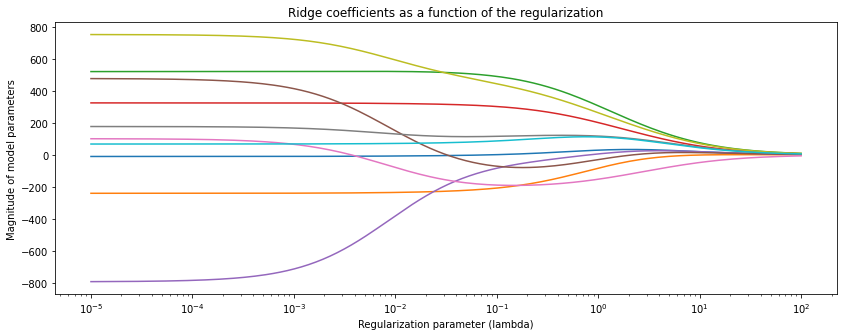

In [15]:
# based on https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Ridge
from matplotlib import pyplot as plt

X, y = load_diabetes(return_X_y=True)

# create ridge coefficients
alphas = np.logspace(-5, 2,  )
ridge_coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    ridge_coefs.append(ridge.coef_)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Regularization parameter (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')

# Sparsity: Ridge vs. Lasso

The Ridge model does not produce sparse weights. Let's now compare it to a Lasso model.

Observe how the Lasso parameters become progressively smaller, until they reach exactly zero, and then they stay at zero.

(-133.00520290292727, 3673.000247757282, -869.357335763701, 828.4524952229654)

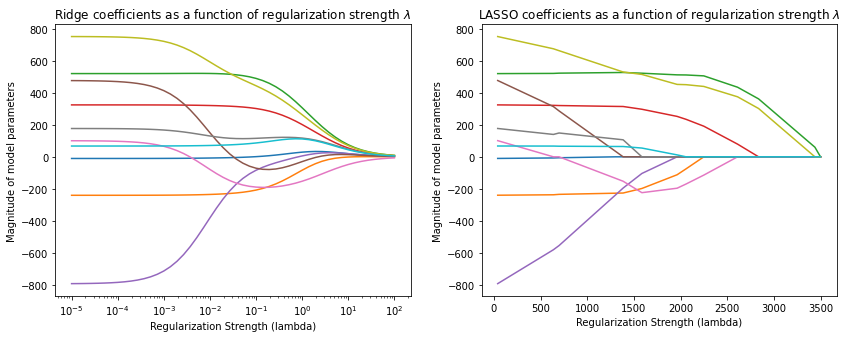

In [17]:
# Based on: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_diabetes
from sklearn.linear_model import lars_path

# create lasso coefficients    
X, y = load_diabetes(return_X_y=True)
_, _, lasso_coefs = lars_path(X, y, method='lasso')
xx = np.sum(np.abs(lasso_coefs.T), axis=1)

# plot ridge coefficients
plt.figure(figsize=(14, 5))
plt.subplot('121')    
plt.plot(alphas, ridge_coefs)
plt.xscale('log')
plt.xlabel('Regularization Strength (lambda)')
plt.ylabel('Magnitude of model parameters')
plt.title('Ridge coefficients as a function of regularization strength $\lambda$')
plt.axis('tight')

# plot lasso coefficients
plt.subplot('122') 
plt.plot(3500-xx, lasso_coefs.T)
ymin, ymax = plt.ylim()
plt.ylabel('Magnitude of model parameters')
plt.xlabel('Regularization Strength (lambda)')
plt.title('LASSO coefficients as a function of regularization strength $\lambda$')
plt.axis('tight')

# Conclusion and Key Ideas

In summary, the key takeaways are:

* When our training dataset is small, models can *overfit*
* This can be detected by measuring performance on a held-out *development* or *test* set sampled from the same *data distribution*.
* Overfitting can be mitigated by regularization; a popular approach is to add the L2 or the L1 norm of $\theta$ to the objective.

# Machine Learning Provably Works

Suppose that we choose $f \in \mathcal{M}$ on a dataset $\mathcal{D}$ of size $n$ sampled IID from $\mathbb{P}$ by minimizing
$$
\frac{1}{n} \sum_{i=1}^n L\left(y^{(i)}, f(x^{(i)}) \right)
$$

Let $f^*$, the best model in $\mathcal{M}$:
$$
f^* = \arg\min_f \mathbb{E}_{(\dot x, \dot y)\sim \mathbb{P}} \left[ L\left(\dot y, f(\dot x \right)) \right]
$$

Then, as $n \to \infty$, the performance of $f$ approaches that of $f^*$.

# Short Proof of Why Machine Learning Works

We say that a classification model $f$ is accurate if its probability of making an error on a new random datapoint is small:

$$ 1 - \mathbb{P} \left[ \dot y= f(\dot x) \right] \leq \epsilon $$

for $\dot{x}, \dot{y} \sim \mathbb{P}$, for some small $\epsilon > 0$ and some definition of accuracy.

We can also say that the model $f$ is inaccurate if it's probability of making an error on a random holdout sample is large:

$$ 1 - \mathbb{P} \left[ \dot y= f(\dot x) \right] \geq \epsilon $$

or equivalently

$$\mathbb{P} \left[ \dot y= f(\dot x) \right] \leq  1-\epsilon.$$

In order to prove that supervised learning works, we will make two simplifying assumptions:
1. We define a model class $\mathcal{M}$ containing $H$ different models
$$\mathcal{M} = \{f_1, f_2,...,f_H\}$$
2. One of these models fits the training data perfectly (is accurate on every point) and we choose that model.

(Both of these assumptions can be relaxed.)

__Claim__: The probability that supervised learning will return an inaccurate model decreases exponentially with training set size $n$.

1. A model $f$ is inaccurate if $\mathbb{P} \left[ \dot y= f(\dot x) \right] \leq  1-\epsilon$.  The probability that an inaccurate model $f$ perfectly fits the training set is at most $\prod_{i=1}^n  \mathbb{P} \left[ \dot y= f(\dot x) \right] \leq (1-\epsilon)^n$.

2. We have $H$ models in $\mathcal{M}$, and any of them could be inaccurate. The probability that at least one of at most $H$ inaccurate models willl fit the training set perfectly is $\leq H (1-\epsilon)^n$.
<!-- 3. If $\delta$ is the probability that a bad classifier is found by supervised learning, then $\delta \leq H (1-\epsilon)^n$ and if
$$ n \geq \frac{\log(\delta/H)}{\log(1-\epsilon)} $$
then supervised learning will work with probability at least $1-\delta$. -->

Therefore, the claim holds.

# An emerging topic: double descent

This example is based on [Daniela Witten's description of double descent](https://twitter.com/daniela_witten/status/1292293102103748609)

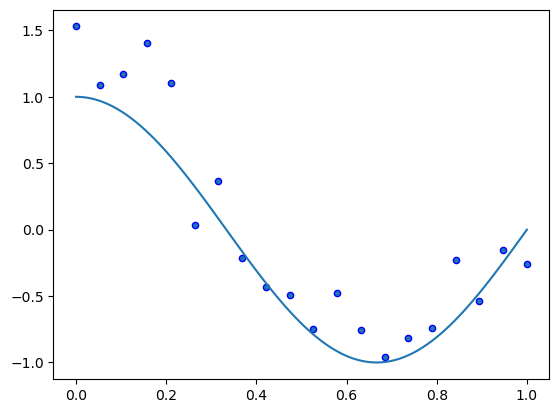

In [92]:
## Make a dataset
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

true_fn = lambda X: np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 20
X = np.linspace(0, 1, n_samples)
y = true_fn(X) + np.random.randn(n_samples) * 0.3

X_test = np.linspace(0, 1, 100)
plt.plot(X_test, true_fn(X_test), label="True function")
plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

Text(0, 0.5, 'Test Error')

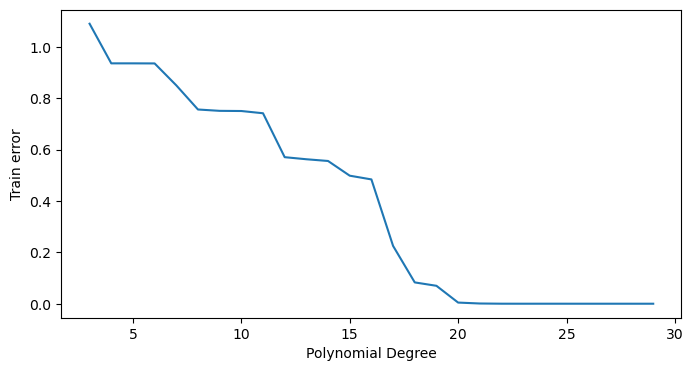

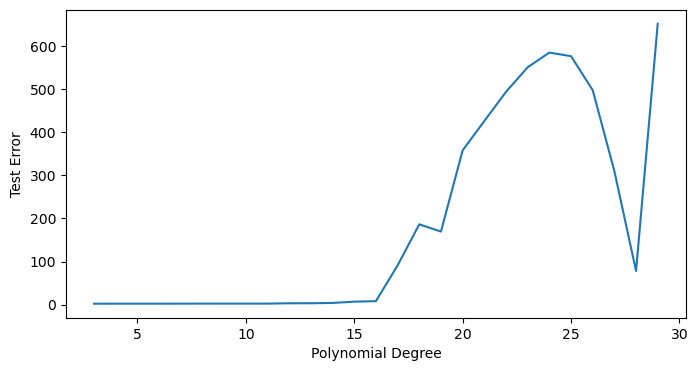

In [93]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LinearRegression

degrees = np.arange(3, 30)
all_train_scores, all_test_scores = list(), list()
# plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    # ax = plt.subplot(1, len(degrees), i + 1)

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("pf", polynomial_features), ("lr", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)
    y_pred_train = pipeline.predict(X[:, np.newaxis])

    X_test = np.linspace(0, 1, 100)
    y_test = true_fn(X_test)
    y_pred_test = pipeline.predict(X_test[:, np.newaxis])

    all_train_scores.append(np.sqrt(np.sum((y_pred_train - y)**2)))
    all_test_scores.append(np.sqrt(np.sum((y_pred_test - y_test)**2)))

plt.figure(figsize=(8, 4))
plt.plot(degrees, all_train_scores)
plt.xlabel('Polynomial Degree')
plt.ylabel('Train error')

plt.figure(figsize=(8, 4))
plt.plot(degrees, all_test_scores)
plt.xlabel('Polynomial Degree')
plt.ylabel('Test Error')

## What's going on?

+ [Double descent](https://www.pnas.org/doi/abs/10.1073/pnas.1903070116) was first described in 2019!
+ It seemingly violates classical statistics, where too many parameters lead to overfitting and thus rising test error.
+ When $p > n$ (more features than data), the model is overparameterized and the training error can be made arbitrarily small.
+ Unexpectedly, the test error starts decreasing again pas $p = n$ (the interpolation threshold, where the number of features is equal to the number of data points)

## How does this happen?

+ The least-squares problem is underdetermined, and so there are multiple possible solutions once we pass the interpolation threshold.
+ Given many equivalent solutions, `scikit-learn`'s `LinearRegression` chooses the solution that minimizes the L2 norm of the coefficients
+ When $p$ gets arbitrarily large, then there are more possible solutions to choose from. The one that minimize the L2 norm of the coefficients ends up being closer to the correct solution, and the test error temporarily decreases.
+ Using ridge regression avoids this problem, because the model is no longer overparameterized.

+ Double descent is a loose argument for why neural networks work so well, despite often having many more parameters than data points. Overparametrization gives them more flexibility to find a good solution.